In [1]:
import os
import time
import logging
import argparse

import cv2
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torch.nn.parallel
import torch.utils.data
import torch.nn as nn

from model.pspnet import PSPNet, DeepLabV3
from util import dataset, transform, config
from PIL import Image
# from util.util import AverageMeter, intersectionAndUnion, check_makedirs, colorize

cv2.ocl.setUseOpenCL(False)

/cfarhomes/psando/miniconda3/envs/seg/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.utils import make_grid

plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs, figsize=(10,10), save_filename=None):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=figsize)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    if save_filename:
        fix.savefig(save_filename, dpi=300)
        
def colorize(gray, palette):
    # gray: numpy array of the label and 1*3N size list palette
    color = Image.fromarray(gray.astype(np.uint8)).convert('P')
    color.putpalette(palette)
    return color

colors_path = 'dataset/voc2012/voc2012_colors.txt'
color_palette = np.loadtxt(colors_path).astype('uint8')

In [3]:
chosen_filename = '2007_001630'

Loaded original img: /vulcanscratch/psando/VOC/VOCdevkit/VOC2012/JPEGImages/2007_001630.jpg
Loaded adv img: /vulcanscratch/psando/semseg_experiments/train_psp/result/imgs_adv_4/adv_2007_001630.png
Loading clean: /vulcanscratch/psando/semseg_experiments/train_psp/result/color/2007_001630.png
Loading clean: /vulcanscratch/psando/semseg_experiments/train_sat_psp/result/color/2007_001630.png
Loading clean: /vulcanscratch/psando/semseg_experiments/train_advprop_psp/result/color/2007_001630.png
Loading adv: /vulcanscratch/psando/semseg_experiments/train_psp/result/color_adv_4/2007_001630.png
Loading adv: /vulcanscratch/psando/semseg_experiments/train_sat_psp/result/color_adv_4/2007_001630.png
Loading adv: /vulcanscratch/psando/semseg_experiments/train_advprop_psp/result/color_adv_4/2007_001630.png


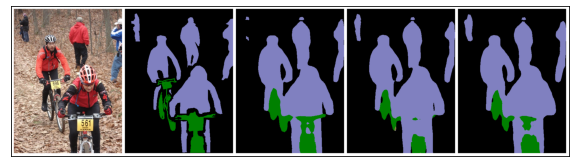

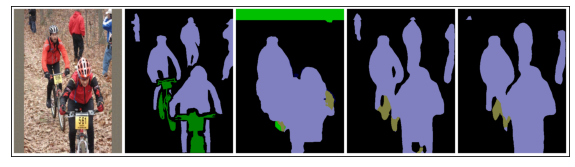

In [5]:
# Load image and appropriate rescale
img_index = chosen_filename.split('.')[0]
experiments_dir = '/vulcanscratch/psando/semseg_experiments/'
run_names = ['train_psp', 'train_sat_psp', 'train_advprop_psp']
results_adv_dir = 'color_adv_4'
results_clean_dir = 'color'

clean_pred_paths = [os.path.join(experiments_dir, run_name, 'result', results_clean_dir, chosen_filename+'.png') for run_name in run_names]
adv_pred_paths = [os.path.join(experiments_dir, run_name, 'result', results_adv_dir, chosen_filename+'.png') for run_name in run_names]


clean_preds = []
adv_preds = []

# Load original image
original_path = os.path.join('/vulcanscratch/psando/VOC/VOCdevkit/VOC2012', 'JPEGImages', chosen_filename+'.jpg')
print(f'Loaded original img: {original_path}')
original_img = cv2.cvtColor(cv2.imread(os.path.join(original_path)), cv2.COLOR_BGR2RGB)
clean_preds.append(torch.from_numpy(original_img.transpose((2,0,1))))
# show(make_grid(torch.from_numpy(original_img.transpose((2,0,1)))))

# Load ground truth
gt_path = os.path.join('/vulcanscratch/psando/VOC/VOCdevkit/VOC2012', 'SegmentationClassAug', chosen_filename+'.png')
gt_to_colorize = cv2.imread(os.path.join(gt_path), cv2.IMREAD_GRAYSCALE)
gt_colorized = colorize(gt_to_colorize, color_palette)
gt_colorized.save(f'gt_{img_index}.png')
gt = cv2.imread(f'gt_{img_index}.png')
clean_preds.append(torch.from_numpy(gt.transpose((2,0,1))))


# Load adversarial image
adv_img_path = os.path.join('/vulcanscratch/psando/semseg_experiments/train_psp/result', 'imgs_adv_4', f'adv_{chosen_filename}.png')
print(f'Loaded adv img: {adv_img_path}')
adv_img = cv2.cvtColor(cv2.imread(os.path.join(adv_img_path)), cv2.COLOR_BGR2RGB)
resize = transforms.Resize(clean_preds[-1].shape[-2:])
adv_preds.append(resize(torch.from_numpy(adv_img.transpose((2,0,1)))))
adv_preds.append(torch.from_numpy(gt.transpose((2,0,1))))


# Load preds using cv2 and plot them
for clean_pred_path in clean_pred_paths:
    pred = cv2.imread(os.path.join(clean_pred_path))
    print(f'Loading clean: {clean_pred_path}')
    pred = pred.transpose((2,0,1))
    clean_preds.append(torch.from_numpy(pred))

for adv_pred_path in adv_pred_paths:
    pred = cv2.imread(os.path.join(adv_pred_path))
    print(f'Loading adv: {adv_pred_path}')
    pred = pred.transpose((2,0,1))
    adv_preds.append(torch.from_numpy(pred))

clean_preds = torch.stack(clean_preds)
adv_preds = torch.stack(adv_preds)
# show(make_grid(clean_preds, nrow=5, padding=10, pad_value=255))
# show(make_grid(adv_preds, nrow=5, padding=10, pad_value=255))
show(make_grid(clean_preds, nrow=5, padding=10, pad_value=255), save_filename=f'clean_pred_{img_index}.png')
show(make_grid(adv_preds, nrow=5, padding=10, pad_value=255), save_filename=f'adv_pred_{img_index}.png')

In [6]:
clean_preds[0].shape

torch.Size([3, 500, 375])

In [8]:
375*5 + 100

1975

In [9]:
500*2 + 100

1100